# Introduction

The purpose of this notebook is to download data and process it. As a result we will get a dataset ready for further analyses and modeling.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

# let matplotlib plots be part of Jupyter Notebook
%matplotlib inline

# set up higher resolution for matplotlib plots
%config InlineBackend.figure_format = 'retina'

# Data loading and processing pipeline

In [2]:
# Change folder
%cd ../src

/Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/src


In [3]:
# execute tests to make sure everything is working as expected
! python -m pytest

============================= test session starts ==============================
platform darwin -- Python 3.6.8, pytest-5.2.2, py-1.8.0, pluggy-0.13.0
rootdir: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski, inifile: tox.ini
collected 22 items                                                             

tests/cleaning/test_extract_gps_from_station_name.py ..                  [  9%]
tests/cleaning/test_pipeline.py ....                                     [ 27%]
tests/cleaning/test_remove_missing_gps.py ..                             [ 36%]
tests/cleaning/test_remove_same_location.py ...                          [ 50%]
tests/features/test_day_of_week.py ..                                    [ 59%]
tests/features/test_holidays.py ...                                      [ 72%]
tests/features/test_hour.py ..                                           [ 81%]
tests/features/test_month.py ..                                          [ 90%]
tests/features/test_season.py ..               

In [4]:
# run data loading and processing pipeline 
# (with soft deleting so that we can inspect everything)
!python run_pipeline.py --remove=0

Pipeline execution started
Root folder set to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals
* GpsFromStationNameExtractor *
--> input data shape:  (461405, 10)
--> output data shape:  (461405, 10)
* GpsFromStationNameExtractor *
--> input data shape:  (461405, 10)
--> output data shape:  (461405, 10)
* SameLocationRemover *
--> input data shape:  (461405, 10)
--> output data shape:  (461405, 11)
* MissingGpsLocationRemover *
--> input data shape:  (461405, 11)
--> output data shape:  (461405, 11)
* SeasonFeature *
--> input data shape:  (461405, 11)
--> output data shape:  (461405, 12)
* HolidaysFeature *
--> input data shape:  (461405, 12)
--> output data shape:  (461405, 13)
* DayOfWeekFeature *
--> input data shape:  (461405, 13)
--> output data shape:  (461405, 14)
* HourFeature *
--> input data shape:  (461405, 14)
--> output data shape:  (461405, 15)
* MonthFeature *
--> input data shape:  (461405, 15)
--> output data shape:  (461405, 16)
Data saved to: /Users

# Post-processing inspection

In [5]:
import os
import pandas as pd

filepath = os.path.join(os.getcwd(), '..', 'data', 'processed', 'bike_rentals.csv')

In [6]:
# load csv and set proper column types
bike_rentals_df = pd.read_csv(filepath)
bike_rentals_df['Rental datetime'] = pd.to_datetime(bike_rentals_df['Rental datetime'])
bike_rentals_df['Return datetime'] = pd.to_datetime(bike_rentals_df['Return datetime'])
bike_rentals_df['Duration'] = pd.to_timedelta(bike_rentals_df['Duration'])

In [7]:
bike_rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461405 entries, 0 to 461404
Data columns (total 16 columns):
Bike number                 461405 non-null int64
Rental datetime             461405 non-null datetime64[ns]
Return datetime             461405 non-null datetime64[ns]
Rental station              461405 non-null object
Return station              461405 non-null object
Duration                    461405 non-null timedelta64[ns]
Rental station latitude     431734 non-null float64
Rental station longitude    431734 non-null float64
Return station latitude     435006 non-null float64
Return station longitude    435006 non-null float64
IsDeleted                   461405 non-null bool
Season                      461405 non-null int64
Holidays                    461405 non-null bool
Rental day of week          461405 non-null int64
Rental hour                 461405 non-null int64
Rental month                461405 non-null int64
dtypes: bool(2), datetime64[ns](2), float64(4), int64

In [8]:
# deleted records may contain NaN values
bike_rentals_df[bike_rentals_df['IsDeleted'] == True].isnull().sum()

Bike number                     0
Rental datetime                 0
Return datetime                 0
Rental station                  0
Return station                  0
Duration                        0
Rental station latitude     29671
Rental station longitude    29671
Return station latitude     26399
Return station longitude    26399
IsDeleted                       0
Season                          0
Holidays                        0
Rental day of week              0
Rental hour                     0
Rental month                    0
dtype: int64

In [9]:
# make sure there are no NaN values in records that are left
assert sum(bike_rentals_df[bike_rentals_df['IsDeleted'] == False].isnull().sum()) == 0

In [10]:
bike_rentals_df.head()

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month
0,57719,2019-06-26 00:00:10,2019-06-26 00:06:19,Skarbowców / Wietrzna,Krzycka / Aleja Karkonoska (Park Południowy),00:06:09,51.073290,16.994850,51.074992,17.007058,False,3,False,3,0,6
1,650480,2019-06-26 00:00:13,2019-06-26 00:06:59,Rynek,Plac Legionów,00:06:46,51.109782,17.030175,51.104413,17.022536,False,3,False,3,0,6
2,650988,2019-06-26 00:00:15,2019-06-26 00:13:32,Poza oficjalną stacją,Wałbrzyska - pętla tramwajowa,00:13:17,NaN,NaN,51.065777,16.988575,True,3,False,3,0,6
3,57603,2019-06-26 00:00:21,2019-06-26 00:23:53,Plac Uniwersytecki (UWr),Legnicka / Wejherowska,00:23:32,51.113871,17.034484,51.125276,16.984447,False,3,False,3,0,6
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False,3,0,6


# Visual inspection of soft deleted records

In [11]:
print(f"Number of soft deleted records: {bike_rentals_df[bike_rentals_df['IsDeleted'] == True].shape[0]}")

Number of soft deleted records: 124379


In [12]:
bike_rentals_df.loc[bike_rentals_df['Rental station latitude'].isnull(), 'Rental station'].value_counts()

Poza oficjalną stacją              29292
Pełczyńska / stacja kolejowa         193
.RELOKACYJNA A1-4                     73
Teststation IT - Adrian (VP)          28
BIKE                                  21
0, 0                                  10
plac Nankiera                          6
recording_80356921                     3
BIKE 57509                             2
Bierutowska 48                         2
.GOTOWE DO REZERWACJI                  2
Podwale 73                             1
Łąkowa                                 1
Generała Stanisława Kopańskiego        1
Eugeniusza Kwiatkowskiego              1
Główna 1a                              1
Kobierzycka 5                          1
Osobowicka                             1
Kazimierza Michalczyka                 1
Benedykta Polaka 16                    1
Stanisława Worcella 8                  1
Czekoladowa 5A                         1
Tadeusza Kościuszki 80a                1
Wiaduktowa                             1
Boguszowska 38b 

In [13]:
bike_rentals_df.loc[bike_rentals_df['Return station latitude'].isnull(), 'Return station'].value_counts()

Poza oficjalną stacją              26114
Pełczyńska / stacja kolejowa         175
Teststation IT - Adrian (VP)          27
BIKE                                  15
.RELOKACYJNA A1-4                     13
0, 0                                   7
plac Nankiera                          6
recording_80356921                     3
BIKE 57509                             2
Bierutowska 48                         2
Mydlana                                1
Sołtysowicka 27e                       1
Eugeniusza Kwiatkowskiego              1
Główna 1a                              1
Sucha 2                                1
Władysława Czaplińskiego 32            1
Centralna 28                           1
Kobierzycka 5                          1
Stanisława Worcella 8                  1
Wilkszyńska 55                         1
Czekoladowa 5A                         1
Wiaduktowa                             1
Boguszowska 38b                        1
15092                                  1
Skarbowców 23a  

## Rentals returned to the same bike station

In [14]:
idx = (bike_rentals_df['IsDeleted'] == True) & \
      (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
print(f"Number of records: {bike_rentals_df.loc[idx, :].shape[0]}")

Number of records: 77822


### Inspection

In [15]:
bike_rentals_df.loc[idx, :]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False,3,0,6
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6
7,57855,2019-06-26 00:01:22,2019-06-26 00:19:56,Kościuszki / Pułaskiego,Kościuszki / Pułaskiego,00:18:34,51.100400,17.045083,51.100400,17.045083,True,3,False,3,0,6
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False,3,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461398,57806,2019-10-30 23:50:00,2019-10-30 23:56:00,Drobnera / Plac Bema,Drobnera / Plac Bema,00:06:00,51.117557,17.040967,51.117557,17.040967,True,4,False,3,23,10
461399,57307,2019-10-30 23:50:00,2019-10-30 23:58:00,Drobnera / Plac Bema,Drobnera / Plac Bema,00:08:00,51.117557,17.040967,51.117557,17.040967,True,4,False,3,23,10
461400,650865,2019-10-30 23:51:00,2019-10-30 23:52:00,Traugutta / Pułaskiego,Traugutta / Pułaskiego,00:01:00,51.104571,17.048102,51.104571,17.048102,True,4,False,3,23,10
461402,57852,2019-10-30 23:52:00,2019-10-30 23:58:00,Plac Dominikański (Galeria Dominikańska),Plac Dominikański (Galeria Dominikańska),00:06:00,51.108004,17.039528,51.108004,17.039528,True,4,False,3,23,10


In [16]:
bike_rentals_df.loc[ (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
                    & (bike_rentals_df['Duration'] < '00:01:00')]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False,3,0,6
17,650544,2019-06-26 00:02:50,2019-06-26 00:03:47,Wróblewskiego (Teki),Wróblewskiego (Teki),00:00:57,51.104110,17.084711,51.104110,17.084711,True,3,False,3,0,6
18,650601,2019-06-26 00:03:04,2019-06-26 00:04:03,Drobnera / Dubois,Drobnera / Dubois,00:00:59,51.117032,17.033499,51.117032,17.033499,True,3,False,3,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461242,650764,2019-10-30 21:43:00,2019-10-30 21:43:00,Bezpieczna / Obornicka,Bezpieczna / Obornicka,00:00:00,51.141560,17.025870,51.141560,17.025870,True,4,False,3,21,10
461312,650100,2019-10-30 22:32:00,2019-10-30 22:32:00,Wita Stwosza / Szewska,Wita Stwosza / Szewska,00:00:00,51.110274,17.034912,51.110274,17.034912,True,4,False,3,22,10
461356,57856,2019-10-30 23:03:00,2019-10-30 23:03:00,Kiełczowska,Kiełczowska,00:00:00,51.145740,17.134930,51.145740,17.134930,True,4,False,3,23,10
461377,57978,2019-10-30 23:15:00,2019-10-30 23:15:00,Plac Kościuszki (Renoma),Plac Kościuszki (Renoma),00:00:00,51.103354,17.030704,51.103354,17.030704,True,4,False,3,23,10


### Duration

In [17]:
total_seconds = bike_rentals_df.loc[idx, 'Duration'].dt.total_seconds();

print(f"Min: {total_seconds.min()}, Max: {total_seconds.max()}")
print(f"Avg: {total_seconds.mean()}, Std: {total_seconds.std()}")

Min: 0.0, Max: 56135.0
Avg: 519.6757472180103, Std: 1381.1563155246454


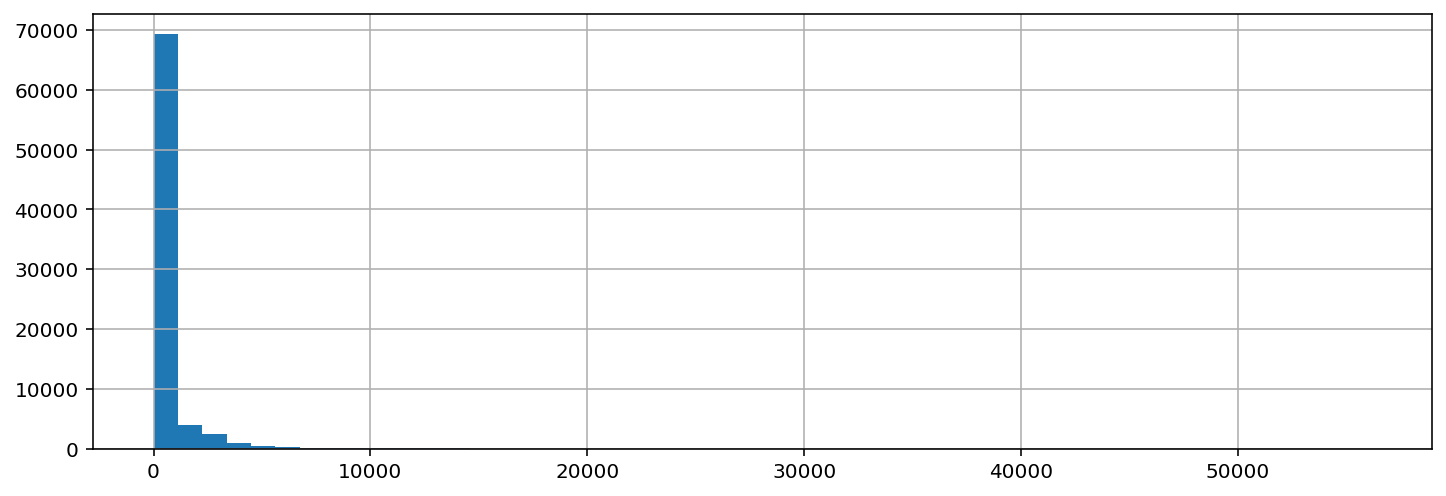

In [18]:
total_seconds.hist(bins=50, figsize=(12, 4));

### Geographical dispersion

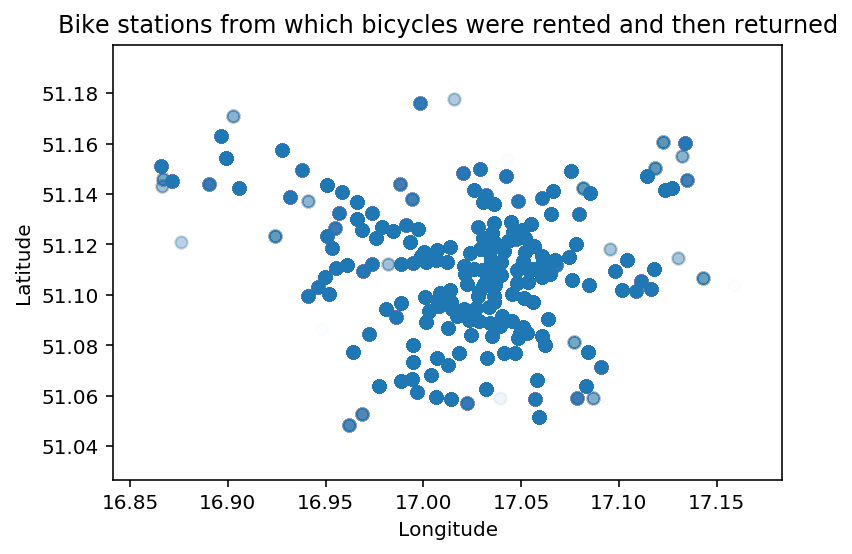

In [19]:
plt.scatter(x=bike_rentals_df.loc[idx, 'Rental station longitude'].values, 
            y=bike_rentals_df.loc[idx, 'Rental station latitude'].values, 
            alpha=0.01)
plt.title('Bike stations from which bicycles were rented and then returned')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

# Run full pipeline

In [20]:
# run data loading and processing pipeline
#!python run_pipeline.py --remove=1